# **Deep Learning Project**

Made by students:
  - **Emanuele Conforti (252122)**
  - **Jacopo Garofalo (252093)**
  - **Gianmarco La Marca (252256)**

## **Environment initialization**

The **aim** of the project is to **generate a report starting from chest x-rays images**.

### **Running the code on Colab**

- Run the following cells if you are on Colab.
- If you are using Kaggle, **do not** run these cells

In [1]:
onColab = False

if onColab:
    ! pip install kaggle
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

In [2]:
if onColab:
    ! kaggle datasets download raddar/chest-xrays-indiana-university

In [3]:
import zipfile
import os

if onColab:
    file_name = "chest-xrays-indiana-university.zip"
    
    # extract the file from the zip
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall("chest_xrays_data")

In [4]:
if onColab:
    !ls chest_xrays_data

In [5]:
if onColab: 
    img_dir = 'chest_xrays_data/images/images_normalized/'
    reports_dir = 'chest_xrays_data/indiana_reports.csv'
    projections_dir = 'chest_xrays_data/indiana_projections.csv'
else:
    img_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
    reports_dir = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
    projections_dir = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'

In [6]:
! pip install pytorch-msssim

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer

from tqdm import tqdm
from tqdm.auto import trange

import torchvision
from torchvision import transforms as T

from pytorch_msssim import ssim  # import SSIM as loss function

In [10]:
torch.backends.cudnn.benchmark = True

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using device: {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "Using CPU")

Using device: Tesla P100-PCIE-16GB


## **Pre-processing**

Here we print the datasets, analyze data inside them and prepare them for the training phase

#### **We first visualize the first rows of the datasets** 

In [11]:
reports_df = pd.read_csv(reports_dir)
reports_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [12]:
projections_df = pd.read_csv(projections_dir)
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


#### **Since we want to use the findings columns as labels (they represent the report we want to generate), we delete all the rows with null findings**

In [13]:
# filter the rows with null findings
reports_filtered = reports_df.dropna(subset=["findings"])

# keep only entries in projections that have a filtered report associated (association through uid)
projections_filtered = projections_df[projections_df["uid"].isin(reports_filtered["uid"])]
reports_filtered.shape, projections_filtered.shape

((3337, 8), (6469, 3))

#### **Split the filtered dataset (containing only the UID column) in train and validation set**

In [14]:
VAL_SIZE = 0.1

uids = reports_filtered.uid.unique()

train_ds, val_ds = train_test_split(
    uids,
    test_size=VAL_SIZE,
    random_state=42
)

len(train_ds), len(val_ds)

(3003, 334)

#### **We create a custom dataset containing only the data we need:**
- **images**
- **tokenized findings**
- **attention mask**

In [15]:
# adjusted dataset
class ChestXRayDataset(Dataset):
    def __init__(self, reports_df, projections_df, image_folder, uids, transforms):
        self.reports_df = reports_df[reports_df["uid"].isin(uids)].reset_index(drop=True)
        self.projections_df = projections_df
        self.image_folder = image_folder
        # a series of transformations to be applied to images before feeding them into a model
        self.transform = transforms

    def __len__(self):
        return len(self.reports_df)

    def __getitem__(self, idx):
        row = self.reports_df.iloc[idx]
        uid = row["uid"]

        # find the path and filename of the associated image
        image_filename = self.projections_df[self.projections_df["uid"] == uid]["filename"].values[0]
        image_path = f"{self.image_folder}/{image_filename}"

        # load and trasform the image
        image = Image.open(image_path).convert("L")  # conversion to grayscale
        image = self.transform(image)

        # return the image, label (finding)
        return image

tf = T.Compose([
    T.Resize((224, 224)),  # resizing for pre-trained models
    T.ToTensor(),
])

train_dataset = ChestXRayDataset(reports_filtered, projections_filtered, img_dir, train_ds, tf)
val_dataset = ChestXRayDataset(reports_filtered, projections_filtered, img_dir, val_ds, tf)

In [16]:
BATCH_SIZE = 64

# create the DataLoader to generate batches of the dataset and iterate over them
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

#### **Create the dataloader, that is we split the data in the dataset previously created in batches. We do this operation for both train set and validation set**

#### **Now we can start building our model. It will mainly be a CustomAutoencoder composed by the following elements:**
- **encoder**: a **convolutional encoder**, that will take the images and encode them in a **latent space**;
- **decoder**: a **transformer**, that will take the latent space generated by the encoder and the findings columns and generate the text (report);

In [17]:
def conv_layer(n_input, n_output, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(n_input, n_output, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(n_output),
        nn.MaxPool2d(2)
    )

In [18]:
def conv_transpose_layer(n_input, n_output, kernel_size, stride=2):
    return nn.Sequential(
        nn.ConvTranspose2d(n_input, n_output, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(n_output)
    )

In [19]:
def feature_recon_layer(n_input):
    return nn.Sequential(
        conv_transpose_layer(n_input, n_input, 4, 1),    # dim += 3
        nn.Conv2d(n_input, n_input, 4, 1),               # dim -= dim-3
        nn.ReLU(),
        nn.BatchNorm2d(n_input)
    )

#### **We first create the AutoencoderCNN. This will take as input the images, encode them and generate again the images. We will use only its encoder in our CustomAutoencoder**

In [20]:
class AutoEncoderCNN(nn.Module):

    def __init__(self, in_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_layer(in_channels, 64, 3),
            conv_layer(64, 128, 3),
            conv_layer(128, 256, 3),
            conv_layer(256, 512, 3)
        )
        # 12x12
        self.decoder = nn.Sequential(
            conv_transpose_layer(512, 256, 4), # (12-1)x2+4 = 26 => 26x26
            feature_recon_layer(256),
            conv_transpose_layer(256, 128, 4), # (26-1)x2+4 = 54 => 54x54
            feature_recon_layer(128),
            conv_transpose_layer(128, 64, 5),  # (54-1)x2+5 = 111 => 111x111
            conv_transpose_layer(64, in_channels, 4)   # (111-1)x2+4 = 224 => 224x224
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)

        return encoded, decoded

In [21]:
class VAE_CNN(nn.Module):

    def __init__(self, in_channels, latent_dim):
        super().__init__()
        self.encoder_conv = nn.Sequential(
            conv_layer(in_channels, 64, 3),
            conv_layer(64, 128, 3),
            conv_layer(128, 256, 3),
            conv_layer(256, 512, 3)
        )
        # Dopo 4 blocchi conv_layer con kernel 3 e maxpool 2, per un input di 224x224,
        # la dimensione spaziale sarà ((((224-3+2)/2)+1)-3+2)/2+1 ... circa 12x12.
        # Quindi la dimensione dell'output appiattito sarà 512 * 12 * 12.
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(512 * 12 * 12, latent_dim)
        self.fc_logvar = nn.Linear(512 * 12 * 12, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, 512 * 12 * 12)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(512, 12, 12))
        self.decoder_conv = nn.Sequential(
            conv_transpose_layer(512, 256, 4), # (12-1)*2 + 4 = 26
            feature_recon_layer(256),
            conv_transpose_layer(256, 128, 4), # (26-1)*2 + 4 = 54
            feature_recon_layer(128),
            conv_transpose_layer(128, 64, 5),  # (54-1)*2 + 5 = 111
            conv_transpose_layer(64, in_channels, 4) # (111-1)*2 + 4 = 224
        )
        self.sigmoid = nn.Sigmoid()
        self.latent_dim = latent_dim

    def encode(self, x):
        h = self.encoder_conv(x)
        h = self.flatten(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = self.unflatten(h)
        reconstructed = self.decoder_conv(h)
        reconstructed = self.sigmoid(reconstructed)
        return reconstructed

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

In [22]:
def train(train_x, val_x, model, epochs=10):     
    criterion = ssim_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch(model, train_x, criterion, optimizer)
            val_loss = eval_epoch(model, val_x, criterion)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

def ssim_loss(output, target):
    """Funzione di perdita SSIM: 1 - SSIM"""
    return 1 - ssim(output, target, data_range=1.0)

def fit_epoch(model, train_x, criterion, optimizer):
    running_loss = 0.0
    processed_data = 0
    
    # for epoch progress
    old_progress = -0.1
    new_progress = 0

    for idx, (inputs) in enumerate(train_x):
        
        new_progress = idx/len(train_x)
        if (new_progress-old_progress >= 0.1):
            print(f"Epoch progress: {new_progress*100}%")
            old_progress = new_progress

        inputs = inputs.to(device)        
        optimizer.zero_grad()
        encoder, outputs = model(inputs)

        # print(f"encoder.shape = {encoder.shape}\noutputs.shape = {outputs.shape}\ninputs.shape = {inputs.shape}")
        
        loss = criterion(outputs, inputs)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
        
    return running_loss / processed_data

def eval_epoch(model, val_x, criterion):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    with torch.no_grad():
        for inputs in val_x:
            inputs = inputs.to(device)
            encoder, outputs = model(inputs)
            
            loss = criterion(outputs, inputs)
            
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    return running_loss / processed_data

In [45]:
learning_rate = 0.0001

beta = 0.001

latent_dimension = 1024

def train_vae(train_x, val_x, model, epochs=20):     
    criterion = ssim_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = vae_fit_epoch(model, train_x, criterion, optimizer)
            val_loss = vae_eval_epoch(model, val_x, criterion)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

def ssim_loss(output, target):
    """Funzione di perdita SSIM: 1 - SSIM"""
    return 1 - ssim(output, target, data_range=1.0)

def kl_divergence(mu, logvar):
    """Calcola la Divergenza di Kullback-Leibler tra una gaussiana
    con media mu e log-varianza logvar e una normale standard."""
    return -0.5 * torch.sum(logvar - mu.pow(2) - logvar.exp() + 1)

def vae_fit_epoch(model, train_x, criterion, optimizer):
    running_loss = 0.0
    processed_data = 0
    
    # for epoch progress
    old_progress = -0.1
    new_progress = 0

    for idx, (inputs) in enumerate(train_x):
        
        new_progress = idx/len(train_x)
        if (new_progress-old_progress >= 0.1):
            print(f"Epoch progress: {new_progress*100}%")
            old_progress = new_progress

        inputs = inputs.to(device)        
        optimizer.zero_grad()
        outputs, mu, logvar = model(inputs)

        # print(outputs)
        # print(f"mu corrente: {mu}")
        # print(f"logvar corrent: {logvar}")
        # print(f"encoder.shape = {encoder.shape}\noutputs.shape = {outputs.shape}\ninputs.shape = {inputs.shape}")

        # loss corrente fatta da solo ssim, scommentare righe sotto per usare anche kl
        loss = criterion(outputs, inputs)
        
        #kl_result = kl_divergence(mu, logvar)
        #print(f"KL demmerda: {kl_result}")
        #loss = loss + beta * kl_result # Beta è un valore usato per "aggiustare" la kl
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
        
    return running_loss / processed_data

def vae_eval_epoch(model, val_x, criterion):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    with torch.no_grad():
        for inputs in val_x:
            inputs = inputs.to(device)
            outputs, mu, logvar = model(inputs)
            
            loss = criterion(outputs, inputs)
            #kl_result = kl_divergence(mu, logvar)
            #loss = loss + beta * kl_result 
            
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    return running_loss / processed_data

In [46]:
model = AutoEncoderCNN(1).to(device)
if (torch.cuda.is_available()):
    model.cuda()

vae_model = VAE_CNN(1, latent_dimension).to(device)
if (torch.cuda.is_available()):
    model.cuda()

#### **Training the AutoencoderCNN**

In [47]:
onVae = True

if onVae:
    history = train_vae(train_loader, val_loader, vae_model, epochs=10)
else:
    history = train(train_loader, val_loader, model, epochs=10)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  10%|█         | 1/10 [01:02<09:23, 62.58s/it]

loss:  0.9100348233104824

Epoch 001 train_loss: 0.9100 val_loss: 0.7094
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  20%|██        | 2/10 [02:04<08:17, 62.18s/it]

loss:  0.9512613804944546

Epoch 002 train_loss: 0.9513 val_loss: 0.9999
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  30%|███       | 3/10 [03:05<07:13, 61.88s/it]

loss:  0.9998352167966006

Epoch 003 train_loss: 0.9998 val_loss: 0.9995
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  40%|████      | 4/10 [04:07<06:11, 61.89s/it]

loss:  0.993659004206821

Epoch 004 train_loss: 0.9937 val_loss: 0.9996
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  50%|█████     | 5/10 [05:10<05:10, 62.04s/it]

loss:  0.9991437864430618

Epoch 005 train_loss: 0.9991 val_loss: 0.9965
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  60%|██████    | 6/10 [06:12<04:08, 62.12s/it]

loss:  0.9770855870875683

Epoch 006 train_loss: 0.9771 val_loss: 0.9958
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  70%|███████   | 7/10 [07:15<03:07, 62.37s/it]

loss:  0.9870115427465944

Epoch 007 train_loss: 0.9870 val_loss: 0.9843
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  80%|████████  | 8/10 [08:17<02:04, 62.23s/it]

loss:  0.9840731424289745

Epoch 008 train_loss: 0.9841 val_loss: 0.9825
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch:  90%|█████████ | 9/10 [09:19<01:02, 62.18s/it]

loss:  0.9800023279347263

Epoch 009 train_loss: 0.9800 val_loss: 0.9770
Epoch progress: 0.0%
Epoch progress: 10.638297872340425%
Epoch progress: 21.27659574468085%
Epoch progress: 31.914893617021278%
Epoch progress: 42.5531914893617%
Epoch progress: 53.191489361702125%
Epoch progress: 63.829787234042556%
Epoch progress: 74.46808510638297%
Epoch progress: 85.1063829787234%
Epoch progress: 95.74468085106383%


epoch: 100%|██████████| 10/10 [10:22<00:00, 62.21s/it]

loss:  0.9702622487749054

Epoch 010 train_loss: 0.9703 val_loss: 0.9604


#### **Plot of the difference between train loss and validation loss**

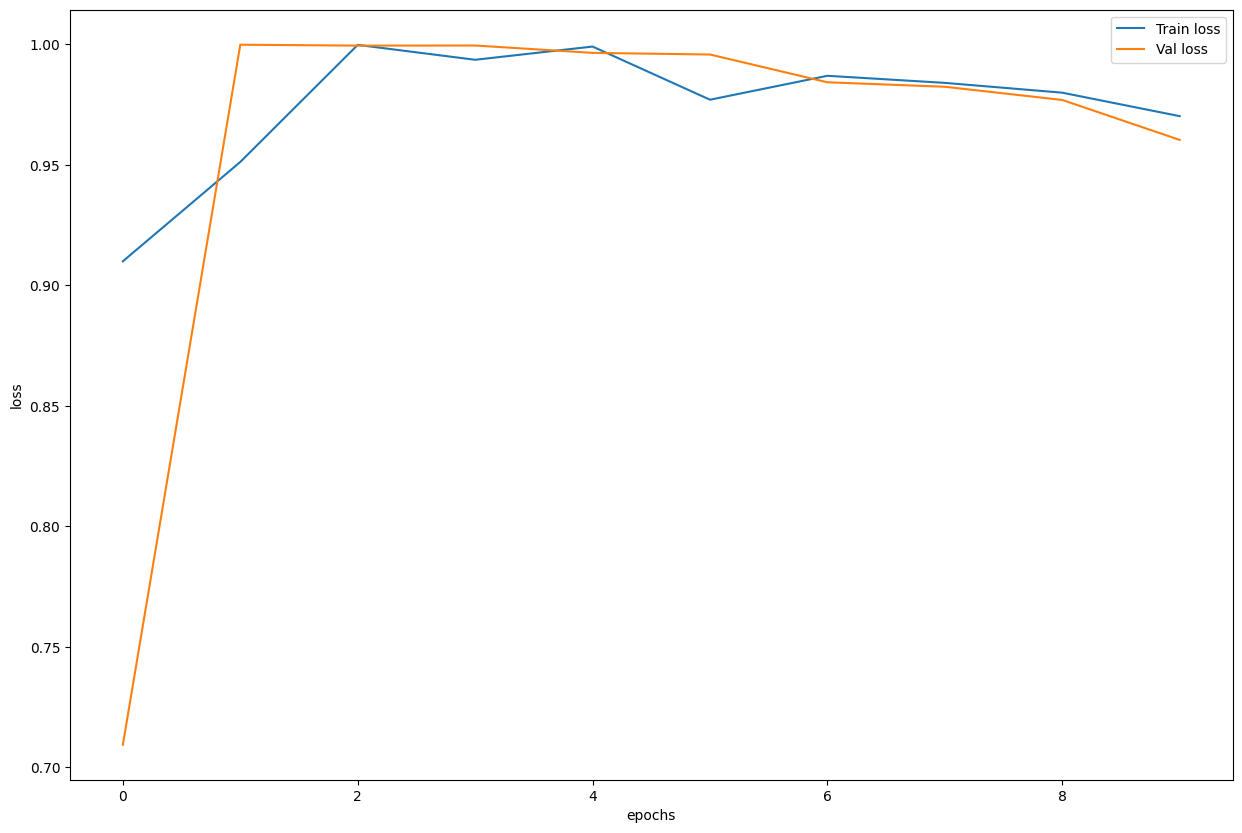

In [48]:
train_loss, val_loss = zip(*history)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
#nome_file = f"grafico_run_latentdim={latent_dimension}_beta={beta}_lr={learning_rate}.png" # Puoi usare una variabile per il numero di run

#plt.savefig(f"/kaggle/working/grafico_run_latentdim={latent_dimension}_beta={beta}_lr={learning_rate}.png")

plt.plot();

#### **Here you can see the generated images by the AutoencoderCNN**

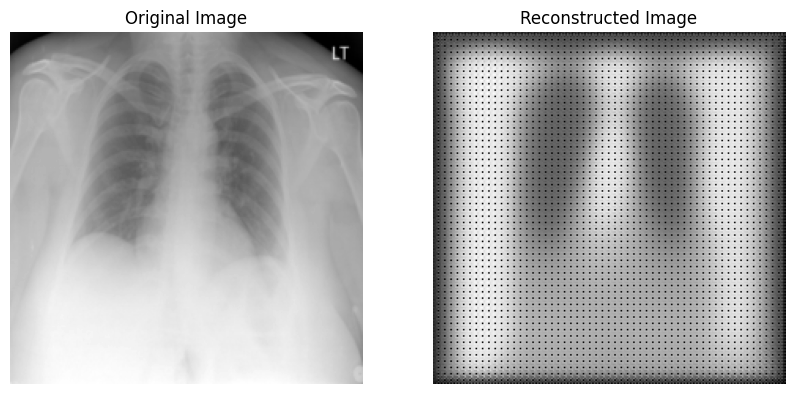

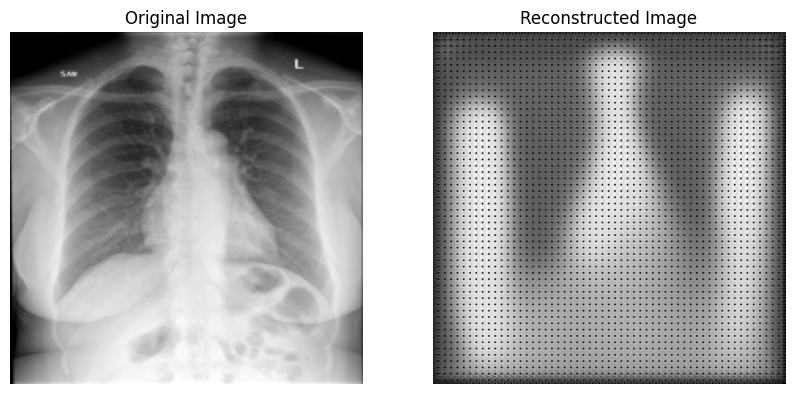

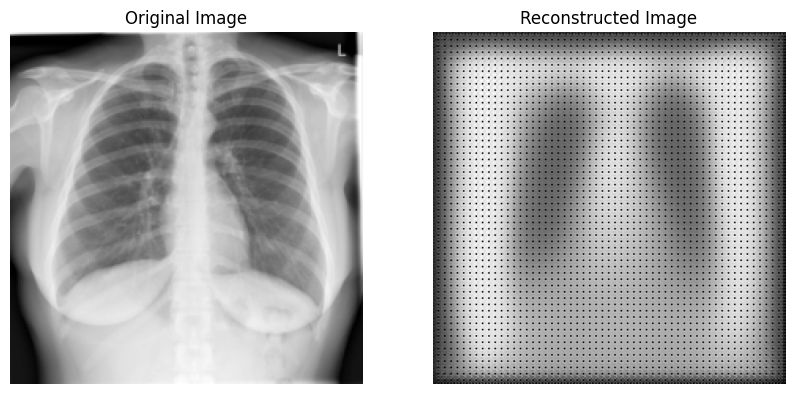

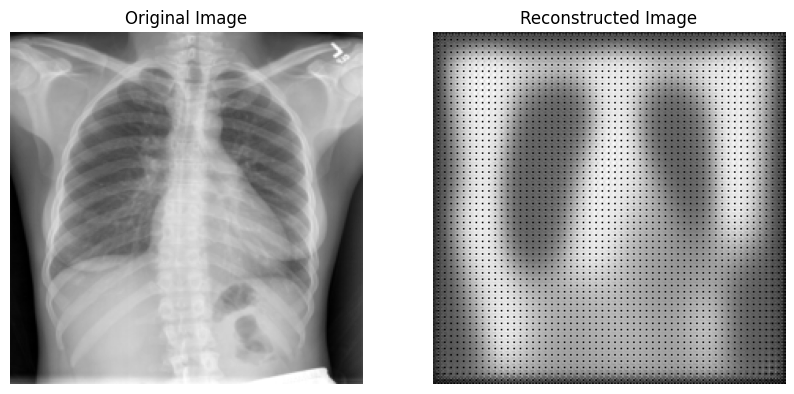

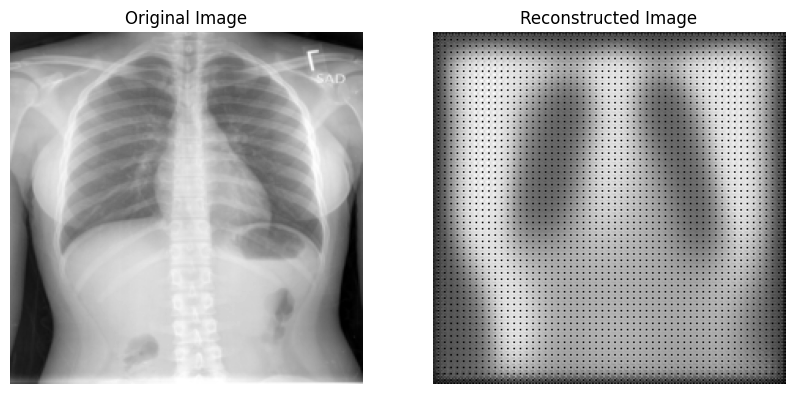

In [49]:
data_iter = iter(val_loader)
inputs = next(data_iter)

inputs = inputs.to(device)

with torch.no_grad():
    _, outputs = model(inputs)

inputs = inputs.cpu().numpy()
outputs = outputs.cpu().numpy()

for idx in range(5):
    original = inputs[idx, 0]
    reconstructed = outputs[idx, 0]
    
    # Plot delle immagini
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(reconstructed, cmap='gray')
    axes[1].set_title("Reconstructed Image")
    axes[1].axis("off")

plt.show()

In [28]:
torch.save(model.encoder.state_dict(), "encoder.pth")

#### **OutOfMemoryError: the following code is used for freeing the GPU cache**

In [29]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()